Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pydicom
import os
import pylab

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import display
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skimage import color

%matplotlib inline

sb.set_style('darkgrid', {'axes.grid' : False})
my_dpi = 96

# RGB Image Feature Extraction


## Question:
Can a Restricted Boltzmann Machine(RBM) increase the accuracy of image classification, more specifically does feature extraction employing RBM increase the accuracy of predicting whether an image falls into one of 10 different catgeories of images. 

### Data:
Image data taken from university of [Toronto](http://www.cs.toronto.edu/~kriz/cifar.html). Data set consists of 7 files each containing pickeled binary arrays.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training files and one test file, each with 10000 images. The test file contains exactly 1000 randomly-selected images from each class. The training files contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Each file contains a dictionary containing two keys.  The ‘data’ key has an array of pixel data as the value.  The ‘labels’ key has a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data. These are the target values for classification.


### Content:
Each color image is 32 x 32. The image data is pickled as separate numpy arrays in six files. The data is contain 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 


In [2]:
# Helpful functions for reading data files

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Function takes a flatten vector of RGB pixels and constructs
# a 3D matrix 32 x 32 x 3 and converts this data to a gray scale image.
# Lastly it flattens the data to 1 d array for processing. 
def recompose_and_convert(pixel_1darray):
    rgb_img = np.reshape(pixel_1darray, (32, 32, 3), order='F')
    gray_scale_img = color.rgb2gray(rgb_img)
    return np.reshape(gray_scale_img, 1024)


Both a color and gray scale image of a car are depicted to show the difficulty in determining the item in the image due the low resolution.

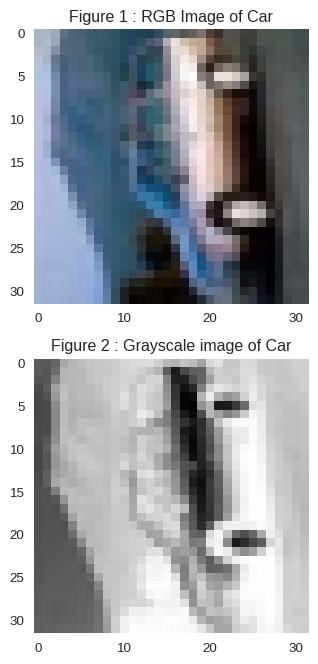

In [21]:
root_path = '/media/ianh/space/ThinkfulData/Isitabird/cifar-10-batches-py/'
img_data = 'data_batch_1'
data = unpickle(root_path+img_data)
flat = data.get(b'data')
array = flat[4,:]

rgb_img = np.reshape(array,(32, 32, 3), order='F')
#plt.imshow(rgb_img, interpolation='nearest')
gray_scale_img = color.rgb2gray(rgb_img)
#plt.imshow(gray_scale_img)

plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
ax1 = plt.subplot(211)
ax1.set_title('Figure 1 : RGB Image of Car')
plt.imshow(rgb_img, interpolation='nearest')

ax2 = plt.subplot(212)
ax2.set_title('Figure 2 : Grayscale image of Car')
plt.imshow(gray_scale_img)

The raw pixel data and labels are read from files.  Each file contains a 2D array 10000 x 3027 of pixels and 10000 integer values 0 through 9 indicating the type of image.  Each 2d bloc of the data is read from a file where each row is reshaped to a 32 x 32 x 3 matrix representing a RGB image. The image is then converted to grayscale using scikit learn image. The resulting grayscale image is flattened to a 1d array containing 1027 pixels. This is then appended to vector. 

In [3]:
# image and label data paths
root_path = '/media/ianh/space/ThinkfulData/Isitabird/cifar-10-batches-py/'
img_data = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
labels_file = 'batches.meta'

# Create empty numpy arrays for RBG pixel data and classification labels
pixel_list =  []
target_labels = []

for item in img_data:
    data = unpickle(root_path+item)
    vector = []
    # big block of pixels 10000 x 3072
    block = data.get(b'data')
    for row in range(0, 10000):
        gray_scale_1d_array = recompose_and_convert(block[row,:])
        vector.append(gray_scale_1d_array)
    
    # vector should result in a size of 10000 x 1024 after conversion
    pixel_list.append(vector)
    target_labels.extend(data.get(b'labels'))
    
pixel_data = np.concatenate(pixel_list)
target_data = np.array(target_labels)

print("\nNumber of Observations in Pixel Data : %d\n" % (pixel_data.shape[0]))
print("Number of Features in Pixel Data : %d\n" % (pixel_data.shape[1]))
print("Length of target labels array : %d\n" % (target_data.shape[0]))

# Read in labels array so that we can make sense of integer values
data = unpickle(root_path+labels_file)
ascii_labels = data.get(b'label_names')

print('Classification Labels')
print('\n% 9s' % 'integer    ascii label')
i = 0

for item in ascii_labels:
    print('% 4d - % 17s' % (i, item.decode('utf-8')))
    i += 1


Number of Observations in Pixel Data : 50000

Number of Features in Pixel Data : 1024

Length of target labels array : 50000

Classification Labels

integer    ascii label
   0 -          airplane
   1 -        automobile
   2 -              bird
   3 -               cat
   4 -              deer
   5 -               dog
   6 -              frog
   7 -             horse
   8 -              ship
   9 -             truck


### Preprocessing and exploratory data analysis

In [4]:
# Check for NaN values in data array
result = np.isnan(np.sum(pixel_data))

print('Does Pixel data have any NaN values? : %s' % ('Yes' if result else 'No') )

# Check for missing values in target array
result = np.isnan(np.sum(target_data))
print('\nDoes label data have any NaN values? : %s' % ('Yes' if result else 'No') )

Does Pixel data have any NaN values? : No

Does label data have any NaN values? : No


In [5]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.2f} secs'.format(label, end - start))


In [8]:
#y = np.where(target_data == 0, 1, 0)
#(y == 1).sum()

5000

## Feature Extraction and Model Building


### Using the Restricted Boltzmann Machine

Time Spent training pipeline : 3224.12 secs


[0 1 2 3 4 5 6 7 8 9]
             precision    recall  f1-score   support

   airplane       0.17      0.56      0.27      2001
 automobile       0.39      0.21      0.27      2013
       bird       0.17      0.07      0.10      2007
        cat       0.29      0.13      0.18      1989
       deer       0.29      0.16      0.21      2006
        dog       0.32      0.25      0.28      1981
       frog       0.22      0.37      0.27      1955
      horse       0.24      0.13      0.17      2001
       ship       0.19      0.19      0.19      1976
      truck       0.33      0.27      0.30      2071

avg / total       0.26      0.24      0.22     20000





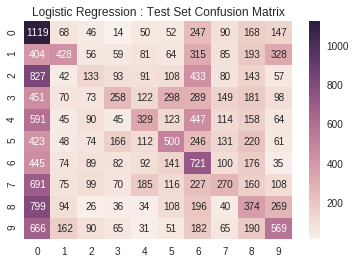

In [15]:
from sklearn.metrics import classification_report
y = target_data
X = pixel_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0)
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 600
logistic.C = 6000.0

pipe_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])


# Training RBM-Logistic Pipeline
with timeblock('Time Spent training pipeline'):
    pipe_classifier.fit(X_train, y_train)
    
y_ = pipe_classifier.predict(X_test)

print('\n')
print(logistic.classes_)
#target_names = ['not an airplane', 'airplane']
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
_ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
_ = plt.title("Logistic Regression : Test Set Confusion Matrix")

Plot the components as constructed by the Restricted Boltzmann Machine to gain an understanding how the model is contributing to the accuracy or lack of accuracy to the classification. 

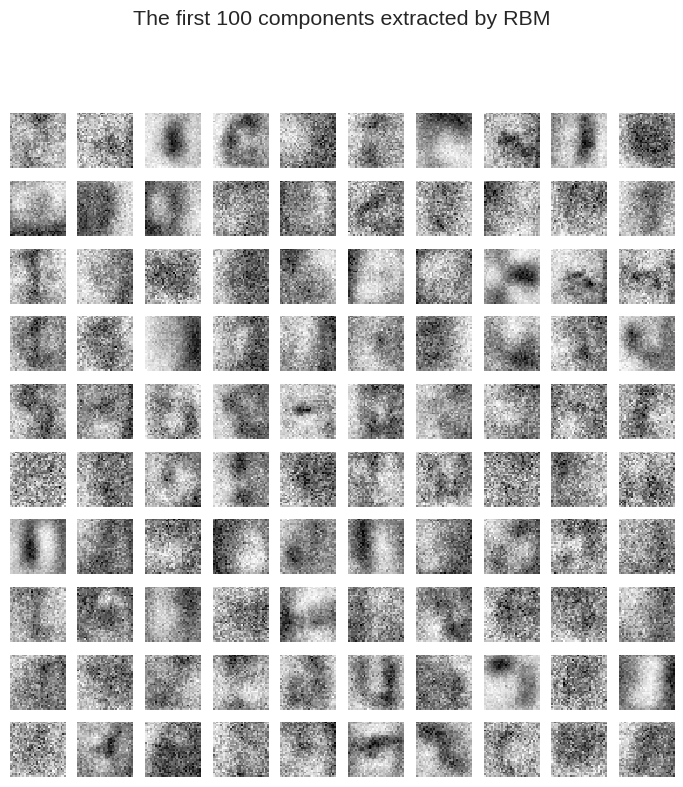

In [16]:
__ = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
for i in range (0,100):
    comp = rbm.components_[i]
    plt.subplot(10, 10, i + 1)
    img = np.reshape(comp,(32, 32))
    plt.imshow(img, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('The first 100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


## Discussion

There have been two attempts at classification of the images. The first used the RGB images which resulted in very poor model performance.  There was a high level of misclassification either if a binary or multi-class classification was performed. It was concluded that the Restricted Boltzmann machine did not know how to make sense of the multiple channels comprising the pixel values.  At one extreme when the model was tasked with classification of airplanes there were no true positives but a high level of sensitivity resulting in f1 score of zero. Only after the color images were converted to grayscale was there a noticeable difference in accuracy.

After image conversion both a binary and multi-class classification was carried out. The multi-class attempt resulted in higher F1 scores. Different values for the number of iterations and the number of components was tried.  Iteration values of 10, 20 and 30 were used. Values between 200 and 600 were used for determining the best classification results.  It is believed that the multi-class attempt resulted in better accuracy scores simply by providing the model with something to differentiate the different classes of images when deciding if an image belong to a particular class.
 
The results above took 54.06 minutes to run yet the results are still rather poor but far better than the binary classification or the first attempt at running the RGB images through the Restricted Boltzmann machine. Yes there is a higher rate of misclassification but the number of true positives is greater than 6 for all classes which was the result for the binary classification of the gray scale images.  